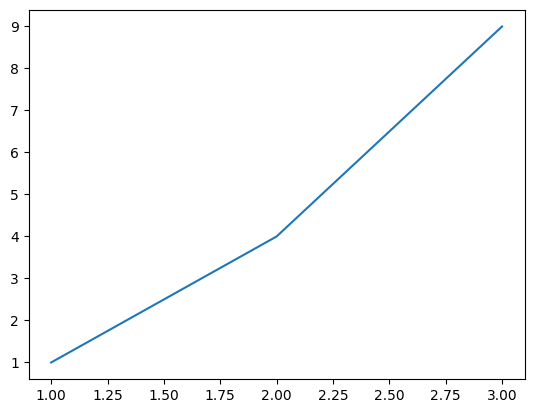

In [1]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3], [1, 4, 9])
plt.show()

In [2]:
import pytz
from datetime import datetime
from gym_mtsim import MtEnvAdvanced, MtSimulator, FOREX_DATA_PATH, Timeframe
from stable_baselines3 import A2C

In [3]:
train_sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=200.,
    stop_out_level=0.2,
    hedge=False,
)

train_sim.download_data(
    symbols=['EURUSD', 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'],
    time_range=(
        datetime(2021, 6, 30, tzinfo=pytz.UTC),
        datetime(2023, 6, 30, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.D1
)

valid_sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=200.,
    stop_out_level=0.2,
    hedge=False,
)

valid_sim.download_data(
    symbols=['EURUSD', 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'],
    time_range=(
        datetime(2023, 1, 7, tzinfo=pytz.UTC),
        datetime(2023, 12, 31, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.D1
)

In [4]:
train_env = MtEnvAdvanced(
    original_simulator=train_sim,
    trading_symbols=['EURUSD'],
    window_size=30,
    multiprocessing_processes=2
)

valid_env = MtEnvAdvanced(
    original_simulator=valid_sim,
    trading_symbols=['EURUSD'],
    window_size=30,
    multiprocessing_processes=2
)

hedging acttivated False
hedging acttivated False


In [5]:
print("train_env information:")

for symbol in train_env.prices:
    print(f"> prices[{symbol}].shape:", train_env.prices[symbol].shape)

print("> signal_features.shape:", train_env.signal_features.shape)
print("> features_shape:", train_env.features_shape)

train_env information:
> prices[EURUSD].shape: (523, 5)
> signal_features.shape: (523, 91)
> features_shape: (30, 91)


In [6]:
print("valid_env information:")

for symbol in valid_env.prices:
    print(f"> prices[{symbol}].shape:", valid_env.prices[symbol].shape)

print("> signal_features.shape:", valid_env.signal_features.shape)
print("> features_shape:", valid_env.features_shape)

valid_env information:
> prices[EURUSD].shape: (254, 5)
> signal_features.shape: (254, 91)
> features_shape: (30, 91)


action: [-79.11105721] reward: -1 done: False
action: [-31.30730116] reward: -1 done: False
action: [-72.16023341] reward: -1 done: False
action: [7.18552596] reward: -1 done: False
action: [-51.8424715] reward: -1 done: False
action: [65.86358417] reward: -1 done: False
action: [-88.15935297] reward: -1 done: False
action: [-70.13977584] reward: -1 done: False
action: [-8.74816978] reward: -1 done: False
action: [8.10431675] reward: -1 done: False
action: [-18.79159116] reward: -1 done: False
action: [-57.62019682] reward: -1 done: False
action: [-68.49998662] reward: -1 done: False
action: [90.6241604] reward: -1 done: False
action: [-42.06750244] reward: -1 done: False
action: [53.01406262] reward: -1 done: False
action: [0.61281945] reward: 1 done: False
action: [6.60050151] reward: 1 done: False
action: [-84.15804784] reward: -1 done: False
action: [30.26800677] reward: -1 done: False
action: [-95.16271301] reward: -1 done: False
action: [-18.92946382] reward: -1 done: False
actio

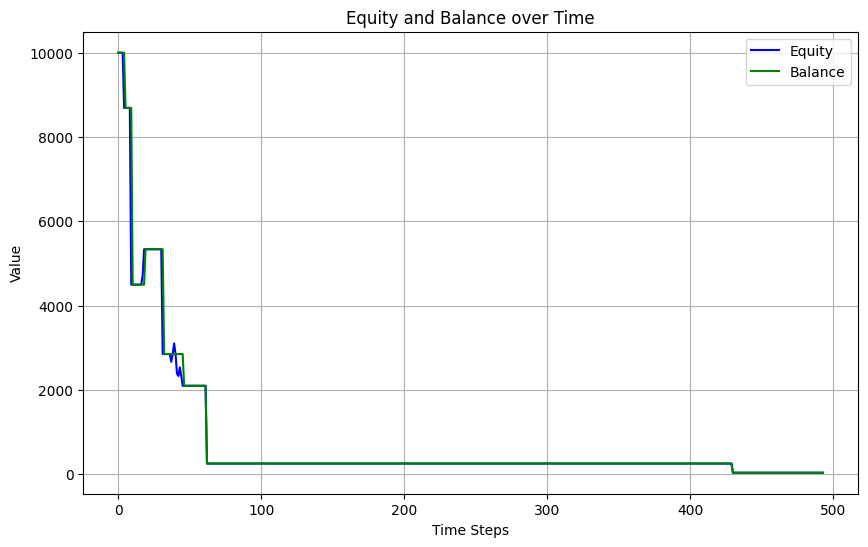

In [7]:
observation = train_env.reset()

while True:
    action = train_env.action_space.sample()
    observation, reward, done, info = train_env.step(action)
    print("action:", action, "reward:", reward, "done:", done)


    if done:
        print("Final Balance:", info['balance'][-1])
        train_env.render(mode='simple_figure')
        break

In [8]:
model = A2C('MultiInputPolicy', train_env, verbose=1)
observation = train_env.reset()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\stefa\anaconda3\envs\RL\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 217      |
|    ep_rew_mean        | -7       |
| time/                 |          |
|    fps                | 146      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.43    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -1.52    |
|    std                | 1.01     |
|    value_loss         | 2.84     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 302      |
|    ep_rew_mean        | -18      |
| time/                 |          |
|    fps                | 135      |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1000     |
|

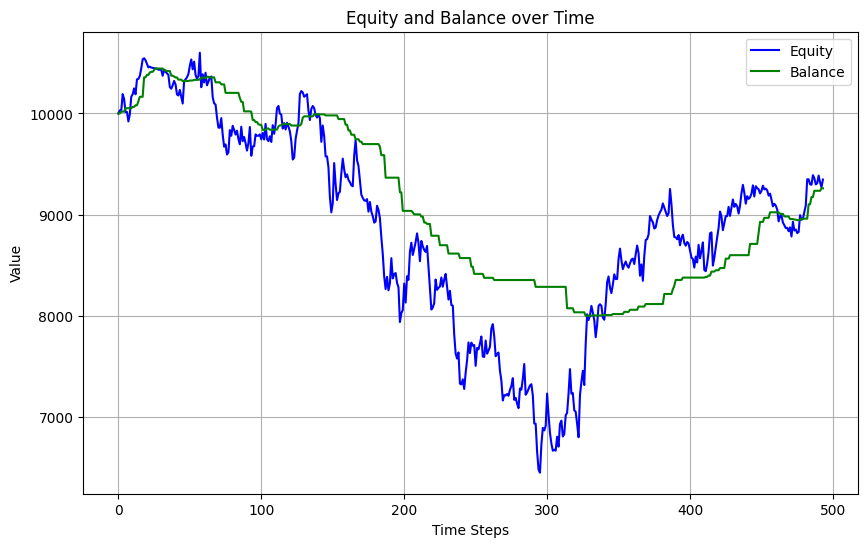

In [9]:
model.learn(total_timesteps=1000)
import time

observation = train_env.reset()
while True:
    action, _states = model.predict(observation, deterministic=True)
    observation, reward, done, info = train_env.step(action)

    if done:
        print("Final Balance:", info['balance'][-1])
        train_env.render(mode='simple_figure')
        break

Final Balance: 10704.300000000012


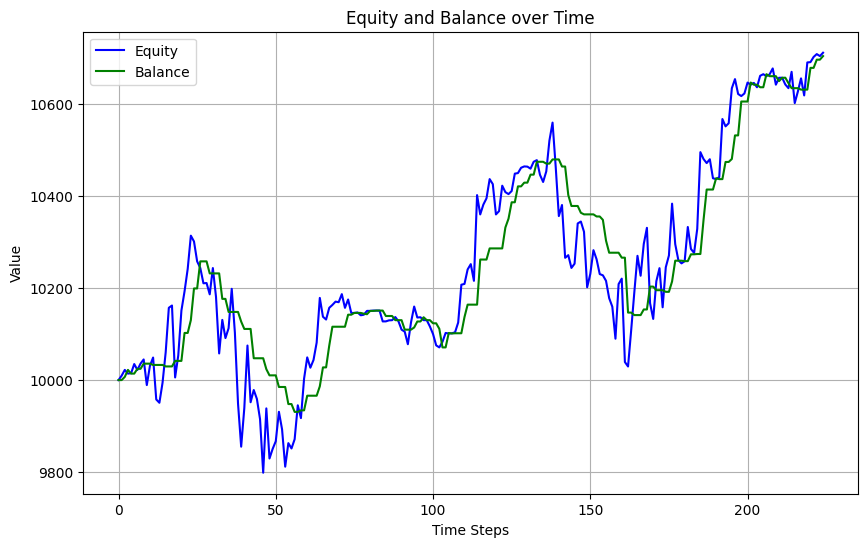

In [10]:
observation = valid_env.reset()
while True:
    action, _states = model.predict(observation, deterministic=True)
    observation, reward, done, info = valid_env.step(action)

    if done:
        print("Final Balance:", info['balance'][-1])
        valid_env.render(mode='simple_figure')
        break

Final Balance train_env: 86807.01569145921


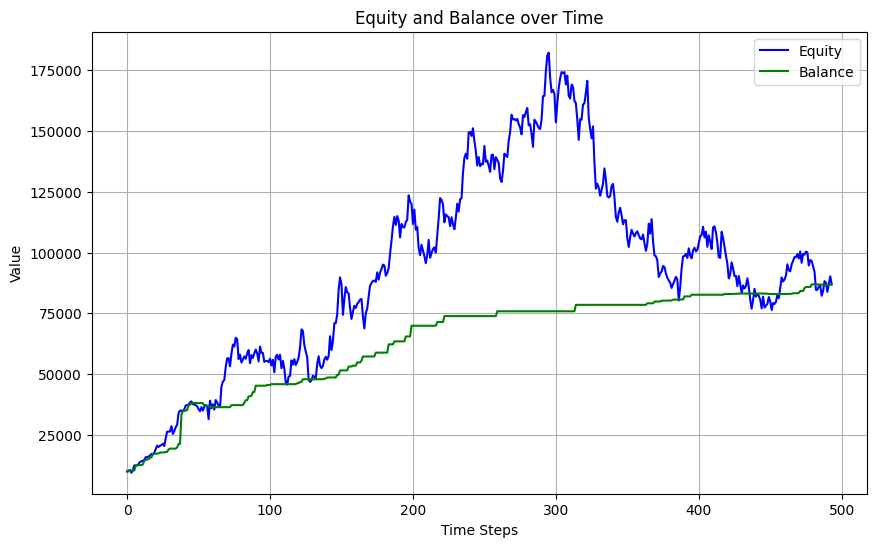

Final Balance valid_env: 4.840000000038742


In [ ]:
from IPython.display import clear_output


episodes = 1000
timesteps = valid_env.signal_features.shape[0]
valid_balance = []


for episode in range(episodes):
    # delete the cell output
    clear_output(wait=True)
    
    model.learn(total_timesteps=timesteps)
    
    observation = train_env.reset()
    while True:
        action, _states = model.predict(observation, deterministic=True)
        observation, reward, done, info = train_env.step(action)

        if done:
            print("Final Balance train_env:", info['balance'][-1])
            train_env.render(mode='simple_figure')
            break
            
    observation = valid_env.reset()
    while True:
        action, _states = model.predict(observation, deterministic=True)
        observation, reward, done, info = valid_env.step(action)

        if done:
            print("Final Balance valid_env:", info['balance'][-1])
            valid_balance.append(info['balance'][-1])
            valid_env.render(mode='simple_figure')
            break
            
    # save the model if it is the best so far
    if valid_balance[-1] == max(valid_balance):
        model.save('best_model')

model = A2C.load('best_model')